In [1]:
# Import Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

In [2]:
# Import Production Data (and State Index)
# Production Data Source
# https://www.kaggle.com/datasets/kevinmorgado/us-energy-generation-2001-2022?select=organised_Gen.csv

# Load the State Index CSV file
state_df = pd.read_csv("Resources/states.csv", usecols = ['State', 'Code'])

# Load the Production CSV file and exclude first column
col_list = ['YEAR', 'MONTH', 'STATE', 'TYPE OF PRODUCER', 'ENERGY SOURCE', 'GENERATION (Megawatthours)']
prod_df = pd.read_csv("Resources/organised_Gen.csv", usecols = col_list)

# Assign title case to column names and rename 'State'
col_list_cased = [col.title() for col in col_list]
prod_df.columns = col_list_cased

# Filter for years 2002 - 2021 to match investment data set
prod_df = prod_df.loc[(prod_df['Year'] > 2001) & (prod_df['Year'] < 2022) & (prod_df['State'] != 'US-TOTAL') & (prod_df['Type Of Producer'] == "Total Electric Power Industry")]

# Filter for common energy types across both data sets
prod_source_list = ['Geothermal', 'Hydroelectric Conventional', 'Other Biomass', 'Solar Thermal and Photovoltaic', 'Wind']
prod_df = prod_df.loc[prod_df['Energy Source'].isin(prod_source_list)]

# Rename energy sources to common convention
prod_df = prod_df.replace(['Hydroelectric Conventional', 'Other Biomass', 'Solar Thermal and Photovoltaic'], 
                          ['Hydroelectric', 'Biomass', 'Solar'])

# Display sample data
prod_df.head(20)

,Year,Month,State,Type Of Producer,Energy Source,Generation (Megawatthours)
20215,2002,1,AK,Total Electric Power Industry,Hydroelectric,118944.0
20217,2002,1,AK,Total Electric Power Industry,Biomass,999.0
20242,2002,1,AL,Total Electric Power Industry,Hydroelectric,947959.0
20244,2002,1,AL,Total Electric Power Industry,Biomass,1622.0
20273,2002,1,AR,Total Electric Power Industry,Hydroelectric,230870.0
20275,2002,1,AR,Total Electric Power Industry,Biomass,288.0
20302,2002,1,AZ,Total Electric Power Industry,Hydroelectric,687079.0
20303,2002,1,AZ,Total Electric Power Industry,Solar,37.0
20304,2002,1,AZ,Total Electric Power Industry,Biomass,6063.0
20336,2002,1,CA,Total Electric Power Industry,Hydroelectric,2515525.0


In [3]:
# Import Investment Data
# Investment Data Source:
# https://www.wctsservices.usda.gov/Energy/Downloads

# Load the Investment Excel file, "Detailed" Sheet
inv_df = pd.read_excel("Resources/EnergyInvestments_DataDownloads.xlsx", sheet_name = "Detailed")

# Unused state list
state_ex = ['American Samoa', 'Commonwealth of the Northern Mariana Islands', 'Federated States of Micronesia', 'Guam', 'Marshall Islands', 'Puerto Rico', 
            'United States Virgin Islands']

# Filter for years 2002 - 2021 to match investment data set, filter out unused states and 'Total' rows
inv_df = inv_df.loc[~inv_df['State'].isin(state_ex)]

# Filter for common energy types across both data sets
inv_source_list = ['Geothermal', 'Hydroelectric', 'Renewable Biomass', 'Solar', 'Wind']
inv_df = inv_df.loc[inv_df['Energy Type'].isin(inv_source_list)]

# Rename energy sources to common convention
inv_df = inv_df.replace('Renewable Biomass', 'Biomass')

# Join with State Index data to get State Abbreviation column
inv_df = pd.merge(inv_df, state_df, on = "State")

# Rename columns
inv_df.rename(columns={"State": "State Name", "Code": "State", "Energy Type": "Energy Source", "Program_Name": "Program Name"}, inplace = True)

# Display sample data
inv_df.head()

,State Name,County,Congressional District,Zip Code,Energy Source,Agency,Year,Program Name,Total Number of Investments,Total Amount of Assistance,Description,State
0,Alabama,Baldwin,AL-01,36507,Biomass,FSA,2010,BCAP Matching Payments (NOFA),2,40736.0,NaN,AL
1,Alabama,Baldwin,AL-01,36551,Biomass,FSA,2010,BCAP Matching Payments (NOFA),1,16509.0,NaN,AL
2,Alabama,Baldwin,AL-01,36567,Biomass,FSA,2010,BCAP Matching Payments (NOFA),1,639.0,NaN,AL
3,Alabama,Baldwin,AL-01,36580,Biomass,FSA,2010,BCAP Matching Payments (NOFA),1,16334.0,NaN,AL
4,Alabama,Baldwin,AL-01,36580,Biomass,RBS,2021,Rural Energy for America Program (REAP),1,7000000.0,Landfill Gas,AL


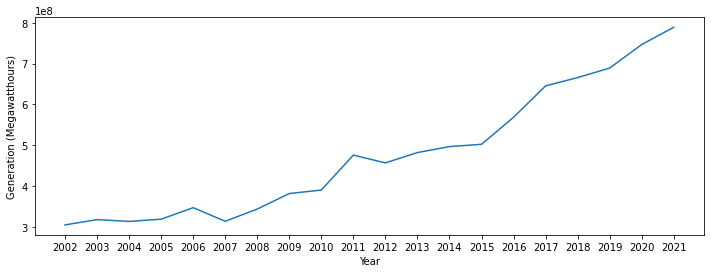

In [4]:

## Look at the trend of total production ('Generation (Megawatthours)') from 2002 - 2021 (all states combined)
# Groupby 'Year'
prod_df_year = prod_df.groupby(["Year"])

# x-axis
x_axis = prod_df_year['Year'].first()

# y-axis
y_axis = prod_df_year['Generation (Megawatthours)'].sum()

# Line plot
plt.figure(figsize = (12, 4))
plt.plot(x_axis, y_axis)
plt.xlabel("Year")
plt.xticks(np.arange(x_axis.min(), x_axis.max() + 1, 1.0))
plt.ylabel("Generation (Megawatthours)")
plt.show()

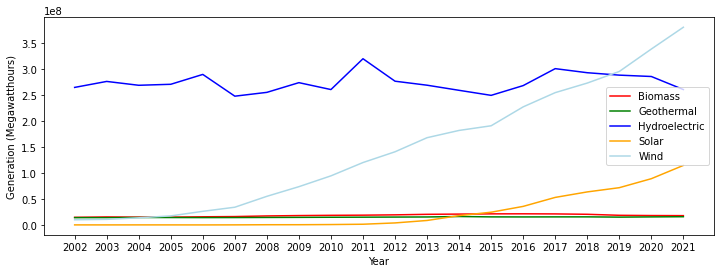

In [5]:

## Look at the trend of total production ('Generation (Megawatthours)') from 2002 - 2021 per Energy Source (all states combined)
# Energy Source List
source_list = ['Biomass', 'Geothermal', 'Hydroelectric', 'Solar', 'Wind']

# Color List
colors = ['red', 'green', 'blue', 'orange', 'lightblue']

# y-axis - Filter for 'Energy Source'
prod_df_bio = prod_df.loc[prod_df['Energy Source'] == source_list[0]].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_geo = prod_df.loc[prod_df['Energy Source'] == source_list[1]].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_hyd = prod_df.loc[prod_df['Energy Source'] == source_list[2]].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_sol = prod_df.loc[prod_df['Energy Source'] == source_list[3]].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_wnd = prod_df.loc[prod_df['Energy Source'] == source_list[4]].groupby(["Year"])['Generation (Megawatthours)'].sum()

# Line plot
plt.figure(figsize = (12, 4))
bio, = plt.plot(x_axis, prod_df_bio, color = colors[0], label = source_list[0])
geo, = plt.plot(x_axis, prod_df_geo, color = colors[1], label = source_list[1])
hyd, = plt.plot(x_axis, prod_df_hyd, color = colors[2], label = source_list[2])
sol, = plt.plot(x_axis, prod_df_sol, color = colors[3], label = source_list[3])
wnd, = plt.plot(x_axis, prod_df_wnd, color = colors[4], label = source_list[4])
plt.xlabel("Year")
plt.xticks(np.arange(x_axis.min(), x_axis.max() + 1, 1.0))
plt.ylabel("Generation (Megawatthours)")
plt.legend(handles = [bio, geo, hyd, sol, wnd], loc = "best")
plt.show()

In [6]:
## Look at the trend of total production ('Generation (Megawatthours)') from 2002 - 2021 per Energy Source (all states combined)

# Filter for 2002, 2021 and ENergy Source
prod_df_bio_02 = prod_df.loc[(prod_df['Energy Source'] == source_list[0]) & (prod_df['Year'] == 2002)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_bio_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[0]) & (prod_df['Year'] == 2021)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_geo_02 = prod_df.loc[(prod_df['Energy Source'] == source_list[1]) & (prod_df['Year'] == 2002)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_geo_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[1]) & (prod_df['Year'] == 2021)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_hyd_02 = prod_df.loc[(prod_df['Energy Source'] == source_list[2]) & (prod_df['Year'] == 2002)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_hyd_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[2]) & (prod_df['Year'] == 2021)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_sol_02 = prod_df.loc[(prod_df['Energy Source'] == source_list[3]) & (prod_df['Year'] == 2002)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_sol_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[3]) & (prod_df['Year'] == 2021)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_wnd_02 = prod_df.loc[(prod_df['Energy Source'] == source_list[4]) & (prod_df['Year'] == 2002)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_wnd_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[4]) & (prod_df['Year'] == 2021)].groupby(["Year"])['Generation (Megawatthours)'].sum()

# Build summary table showing descending movement per energy source
summary = pd.DataFrame({'Energy Source': source_list,
                       'Movement 2021 vs 2002':[(list(prod_df_bio_21)[0] / list(prod_df_bio_02)[0]) - 1,
                                                (list(prod_df_geo_21)[0] / list(prod_df_geo_02)[0]) - 1,
                                                (list(prod_df_hyd_21)[0] / list(prod_df_hyd_02)[0]) - 1,
                                                (list(prod_df_sol_21)[0] / list(prod_df_sol_02)[0]) - 1,
                                                (list(prod_df_wnd_21)[0] / list(prod_df_wnd_02)[0]) - 1]})
summary = summary.sort_values(by=['Movement 2021 vs 2002'], ascending = False)
summary['Movement 2021 vs 2002'] = summary['Movement 2021 vs 2002'].map("{:,.0%}".format)
summary


,Energy Source,Movement 2021 vs 2002
3,Solar,"20,569%"
4,Wind,"3,568%"
0,Biomass,22%
1,Geothermal,12%
2,Hydroelectric,-2%


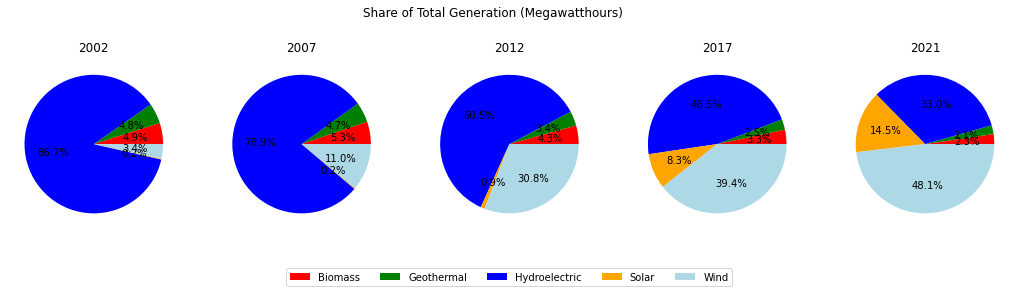

In [7]:
## Look at the trend of share total production ('Generation (Megawatthours)') every five years from 2002 - 2021 per Energy Source (all states combined)

# Filter for every five years - 2002, 2007, 2012, 2017, 2021
prod_df_02 = prod_df.loc[prod_df['Year'] == 2002].groupby(['Energy Source'])['Generation (Megawatthours)'].sum()
prod_df_07 = prod_df.loc[prod_df['Year'] == 2007].groupby(['Energy Source'])['Generation (Megawatthours)'].sum()
prod_df_12 = prod_df.loc[prod_df['Year'] == 2012].groupby(['Energy Source'])['Generation (Megawatthours)'].sum()
prod_df_17 = prod_df.loc[prod_df['Year'] == 2017].groupby(['Energy Source'])['Generation (Megawatthours)'].sum()
prod_df_21 = prod_df.loc[prod_df['Year'] == 2021].groupby(['Energy Source'])['Generation (Megawatthours)'].sum()

# y labels
label_source = prod_df.groupby(['Energy Source'])['Energy Source'].first()

# Build pie chart subplots
fig, axs = plt.subplots(1, 5, figsize=(18, 4), sharey=True)
axs[0].pie(list(prod_df_02), colors = colors, autopct="%1.1f%%")
axs[0].title.set_text('2002')
axs[1].pie(list(prod_df_07), colors = colors, autopct="%1.1f%%")
axs[1].title.set_text('2007')
axs[2].pie(list(prod_df_12), colors = colors, autopct="%1.1f%%")
axs[2].title.set_text('2012')
axs[3].pie(list(prod_df_17), colors = colors, autopct="%1.1f%%")
axs[3].title.set_text('2017')
axs[4].pie(list(prod_df_21), colors = colors, autopct="%1.1f%%")
axs[4].title.set_text('2021')
fig.suptitle('Share of Total Generation (Megawatthours)')
fig.legend(list(label_source), loc='lower center', ncol=len(list(label_source)), bbox_transform=fig.transFigure)


In [8]:
## Look at share of total production ('Generation (Megawatthours)') per Energy Source per State in 2021

# Filter by 2021 and group by State for ALL Energy Sources combined
prod_df_state = prod_df.loc[prod_df['Year'] == 2021].groupby(['State'])['Generation (Megawatthours)'].sum()

# Filter by 2021 and group by State for each Energy Source
prod_df_bio_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[0]) & (prod_df['Year'] == 2021)].groupby(["State"])['Generation (Megawatthours)'].sum()
prod_df_geo_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[1]) & (prod_df['Year'] == 2021)].groupby(["State"])['Generation (Megawatthours)'].sum()
prod_df_hyd_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[2]) & (prod_df['Year'] == 2021)].groupby(["State"])['Generation (Megawatthours)'].sum()
prod_df_sol_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[3]) & (prod_df['Year'] == 2021)].groupby(["State"])['Generation (Megawatthours)'].sum()
prod_df_wnd_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[4]) & (prod_df['Year'] == 2021)].groupby(["State"])['Generation (Megawatthours)'].sum()

# Merge datasets to show evergy sources side-by-side
state_pct = pd.merge(prod_df_state, prod_df_bio_21, how = 'left', on = "State")
state_pct.rename(columns={"Generation (Megawatthours)_x": "Total", "Generation (Megawatthours)_y": source_list[0]}, inplace = True)
state_pct = pd.merge(state_pct, prod_df_geo_21, how = 'left', on = "State")
state_pct.rename(columns={"Generation (Megawatthours)": source_list[1]}, inplace = True)
state_pct = pd.merge(state_pct, prod_df_hyd_21, how = 'left', on = "State")
state_pct.rename(columns={"Generation (Megawatthours)": source_list[2]}, inplace = True)
state_pct = pd.merge(state_pct, prod_df_sol_21, how = 'left', on = "State")
state_pct.rename(columns={"Generation (Megawatthours)": source_list[3]}, inplace = True)
state_pct = pd.merge(state_pct, prod_df_wnd_21, how = 'left', on = "State")
state_pct.rename(columns={"Generation (Megawatthours)": source_list[4]}, inplace = True)
state_pct = state_pct.fillna(0)

# Create new columns for % share of total production
state_pct['Biomass %'] = (state_pct[source_list[0]] / state_pct['Total'])
state_pct['Geothermal %'] = (state_pct[source_list[1]] / state_pct['Total'])
state_pct['Hydroelectric %'] = (state_pct[source_list[2]] / state_pct['Total'])
state_pct['Solar %'] = (state_pct[source_list[3]] / state_pct['Total'])
state_pct['Wind %'] = (state_pct[source_list[4]] / state_pct['Total'])
state_pct = state_pct.iloc[:, 6:11]
state_pct

,Biomass %,Geothermal %,Hydroelectric %,Solar %,Wind %
State,,,,,
AK,0.021093,0.000000,0.908719,0.000000,0.070188
AL,0.002903,0.000000,0.959141,0.037957,0.000000
AR,0.019072,0.000000,0.886010,0.094918,0.000000
AZ,0.001543,0.000000,0.411838,0.473327,0.113292
CA,0.032963,0.145859,0.185523,0.436547,0.199108
CO,0.004324,0.000000,0.089103,0.094817,0.811755
CT,0.431041,0.000000,0.294164,0.263201,0.011594
DC,0.681995,0.000000,0.000000,0.318005,0.000000
DE,0.517045,0.000000,0.000000,0.447665,0.035291


In [9]:
## Look at Top 5 states per Energy Source in 2021

# Sort state_pct table by each Energy Source (descending)
bio_pct = state_pct.sort_values(by=['Biomass %'], ascending = False)
bio = list(bio_pct.iloc[0:5, 0].index)
geo_pct = state_pct.sort_values(by=['Geothermal %'], ascending = False)
geo = list(geo_pct.iloc[0:5, 1].index)
hyd_pct = state_pct.sort_values(by=['Hydroelectric %'], ascending = False)
hyd = list(hyd_pct.iloc[0:5, 2].index)
sol_pct = state_pct.sort_values(by=['Solar %'], ascending = False)
sol = list(sol_pct.iloc[0:5, 3].index)
wnd_pct = state_pct.sort_values(by=['Wind %'], ascending = False)
wnd = list(wnd_pct.iloc[0:5, 4].index)

# Create summary dataframe to show the top 5 states for each Energy Source
summary = pd.DataFrame({'Rank': np.arange(1, 6, 1),
                        'Biomass %': bio,
                        'Geothermal %': geo,
                        'Hydroelectric %': hyd,
                        'Solar %': sol,
                        'Wind %': wnd})
summary

,Rank,Biomass %,Geothermal %,Hydroelectric %,Solar %,Wind %
0,1,DC,NV,KY,MS,KS
1,2,DE,CA,TN,FL,IA
2,3,CT,HI,AL,NJ,IL
3,4,NJ,UT,AK,UT,OK
4,5,RI,ID,AR,VA,WY


In [10]:
# Import Census Data
# Census Data Sources

# https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html
# https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-total.html
# https://www.census.gov/programs-surveys/popest/technical-documentation/research/evaluation-estimates.2010.html#list-tab-Y660N3MTL49GQLLYDJ

years = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
        2017, 2018, 2019, 2020, 2021]

census_df = pd.DataFrame(columns=['State', 'Population', 'Year'])

state = []
population = []
iterationyear = []

for year in years:
        
    if year < 2011:
        
        popappend = "POPESTIMATE" + str(year)
        
        pop_df = pd.read_csv("Resources/co-est2010-alldata.csv", encoding='ISO-8859-1')
        pop_df = pop_df[[popappend, 'STNAME', 'CTYNAME']]
        pop_df = pop_df.rename(columns={popappend: "Population", "STNAME": "State"})
       
        # This specific dataset is broken down by city pop as well, but the full state pop
        # is held in a 'city' that is the state name, so dropping any rows where
        # the state name is not equal to the city name.
        pop_df = pop_df[pop_df.State == pop_df.CTYNAME]
       
        for ind in pop_df.index:
            state.append(pop_df['State'][ind])
            population.append(pop_df['Population'][ind])
            iterationyear.append(year)
            
    if (year > 2010 and year < 2020):
    
        popappend = "POPESTIMATE" + str(year)
        pop_df = pd.read_csv("Resources/nst-est2019-alldata.csv", encoding='ISO-8859-1')
        pop_df = pop_df[[popappend, 'NAME']]
        pop_df = pop_df.rename(columns={popappend: "Population", "NAME": "State"})
        
        for ind in pop_df.index:
            state.append(pop_df['State'][ind])
            population.append(pop_df['Population'][ind])
            iterationyear.append(year)
    
    if year > 2019:
    
        popappend = "POPESTIMATE" + str(year)
        pop_df = pd.read_csv("Resources/NST-EST2021-alldata.csv", encoding='ISO-8859-1')
        pop_df = pop_df[[popappend, 'NAME']]
        pop_df = pop_df.rename(columns={popappend: "Population", "NAME": "State"})
        
        for ind in pop_df.index:
            state.append(pop_df['State'][ind])
            population.append(pop_df['Population'][ind])
            iterationyear.append(year)
        
        
census_df['State'] = state
census_df['Population'] = population
census_df['Year'] = iterationyear
                                     
#print(census_df)

cleaned_census_df = census_df.groupby(['State', 'Year'])["Population", "Year"].sum()

cleaned_census_df = pd.merge(cleaned_census_df, state_df, how = "left", on = "State")

cleaned_census_df.rename(columns={"State": "State Name", "Code": "State"}, inplace = True)
cleaned_census_df

#cleaned_census_df.head()

#cleaned_census_df.to_csv("output_data/census_data.csv")


C:\Users\range\AppData\Local\Temp\ipykernel_11376\1894054204.py:68: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cleaned_census_df = census_df.groupby(['State', 'Year'])["Population", "Year"].sum()


,State Name,Population,Year,State
0,Alabama,4471462,2002,AL
1,Alabama,4489876,2003,AL
2,Alabama,4510588,2004,AL
3,Alabama,4542912,2005,AL
4,Alabama,4594911,2006,AL
...,...,...,...,...
1081,Wyoming,578931,2017,WY
1082,Wyoming,577601,2018,WY
1083,Wyoming,578759,2019,WY
1084,Wyoming,577267,2020,WY


In [11]:
invest_df = inv_df.drop(columns=['County','Agency','Program Name','Congressional District','Zip Code','Description'])

#Getting all of the data for each year under each state
invest_df.groupby(['State', 'Year', 'Energy Source'], as_index=False).agg('sum')
invest_df


,State Name,Energy Source,Year,Total Number of Investments,Total Amount of Assistance,State
0,Alabama,Biomass,2010,2,40736.00,AL
1,Alabama,Biomass,2010,1,16509.00,AL
2,Alabama,Biomass,2010,1,639.00,AL
3,Alabama,Biomass,2010,1,16334.00,AL
4,Alabama,Biomass,2021,1,7000000.00,AL
...,...,...,...,...,...,...
14348,Wyoming,Wind,2006,1,5014.00,WY
14349,Wyoming,Wind,2007,1,33000.00,WY
14350,Wyoming,Wind,2006,1,14200.00,WY
14351,Wyoming,Wind,2006,1,13666.88,WY


In [12]:
#Aggregating the total amount of investment throughout the entire 2 decades by each State and Energy Source

wind_inv = invest_df.loc[invest_df['Energy Source'] == 'Wind'].groupby(['State'])['Total Amount of Assistance'].sum()
bio_inv = invest_df.loc[invest_df['Energy Source'] == 'Biomass'].groupby(['State'])['Total Amount of Assistance'].sum()
solar_inv = invest_df.loc[invest_df['Energy Source'] == 'Solar'].groupby(['State'])['Total Amount of Assistance'].sum()
geo_inv = invest_df.loc[invest_df['Energy Source'] == 'Geothermal'].groupby(['State'])['Total Amount of Assistance'].sum()
hydro_inv = invest_df.loc[invest_df['Energy Source'] == 'Hydroelectric'].groupby(['State'])['Total Amount of Assistance'].sum()

In [13]:
#Turn the variables into a DataFrame of each Energy Source by State
energy_inv_total = pd.DataFrame({
                                "Wind": wind_inv,
                                "Biomass": bio_inv,
                                "Hydroelectric": hydro_inv,
                                "Solar": solar_inv,
                                "Geothermal": geo_inv
})
#Formatting columns for total amount of dollars invested
energy_inv_total['Wind'] = energy_inv_total['Wind']
energy_inv_total['Biomass'] = energy_inv_total['Biomass']
energy_inv_total['Hydroelectric'] = energy_inv_total['Hydroelectric']
energy_inv_total['Solar'] = energy_inv_total['Solar']
energy_inv_total['Geothermal'] = energy_inv_total['Geothermal']

energy_inv_total.reset_index()

,State,Wind,Biomass,Hydroelectric,Solar,Geothermal
0,AK,2.757067e+07,7.344598e+06,53877554.00,5.567280e+06,NaN
1,AL,NaN,3.731169e+07,NaN,2.462549e+06,3875.00
2,AR,1.498100e+04,3.780391e+07,NaN,1.388855e+08,669875.00
3,AZ,4.976262e+04,9.021376e+06,NaN,2.130279e+08,NaN
4,CA,1.689610e+05,2.281292e+08,348750.00,9.157084e+07,NaN
5,CO,2.333880e+05,1.351786e+07,13900954.00,9.305336e+06,184194.00
6,CT,NaN,2.700024e+06,420000.00,2.816940e+06,45374.00
7,DE,NaN,3.920990e+06,NaN,2.711376e+07,NaN
8,FL,NaN,1.519637e+08,NaN,1.102959e+08,NaN
9,GA,NaN,2.137113e+08,NaN,3.139146e+07,25491.00


In [14]:
energy_inv_total = energy_inv_total.fillna(0)
energy_inv_total.reset_index()

,State,Wind,Biomass,Hydroelectric,Solar,Geothermal
0,AK,2.757067e+07,7.344598e+06,53877554.00,5.567280e+06,0.00
1,AL,0.000000e+00,3.731169e+07,0.00,2.462549e+06,3875.00
2,AR,1.498100e+04,3.780391e+07,0.00,1.388855e+08,669875.00
3,AZ,4.976262e+04,9.021376e+06,0.00,2.130279e+08,0.00
4,CA,1.689610e+05,2.281292e+08,348750.00,9.157084e+07,0.00
5,CO,2.333880e+05,1.351786e+07,13900954.00,9.305336e+06,184194.00
6,CT,0.000000e+00,2.700024e+06,420000.00,2.816940e+06,45374.00
7,DE,0.000000e+00,3.920990e+06,0.00,2.711376e+07,0.00
8,FL,0.000000e+00,1.519637e+08,0.00,1.102959e+08,0.00
9,GA,0.000000e+00,2.137113e+08,0.00,3.139146e+07,25491.00


In [15]:
energy_inv_total['Wind'] = energy_inv_total['Wind'].astype(int)
energy_inv_total['Biomass'] = energy_inv_total['Biomass'].astype(int)
energy_inv_total['Hydroelectric'] = energy_inv_total['Hydroelectric'].astype(int)
energy_inv_total['Solar'] = energy_inv_total['Solar'].astype(int)
energy_inv_total['Geothermal'] = energy_inv_total['Geothermal'].astype(int)
energy_inv_total

,Wind,Biomass,Hydroelectric,Solar,Geothermal
State,,,,,
AK,27570669,7344597,53877554,5567280,0
AL,0,37311692,0,2462549,3875
AR,14981,37803910,0,138885525,669875
AZ,49762,9021376,0,213027922,0
CA,168961,228129156,348750,91570835,0
CO,233388,13517855,13900954,9305336,184194
CT,0,2700023,420000,2816940,45374
DE,0,3920990,0,27113758,0
FL,0,151963727,0,110295906,0


<AxesSubplot:title={'center':'Investment of Energy Source Per State'}, xlabel='State', ylabel='Investment in Dollars (in Hundred Millions)'>

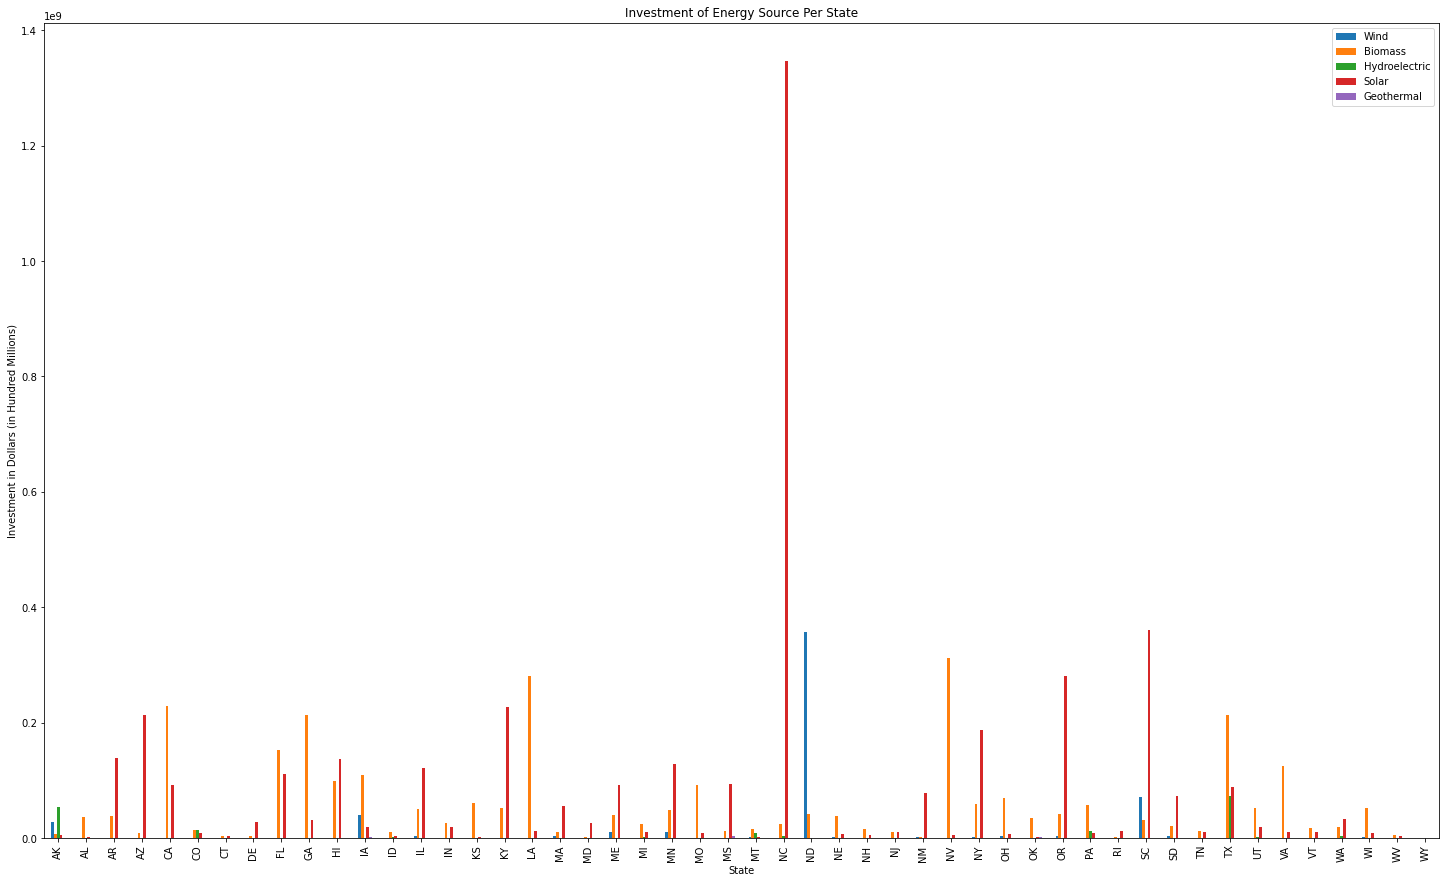

In [16]:
energy_inv_total.plot.bar(figsize =(25,15), title= 'Investment of Energy Source Per State',ylabel='Investment in Dollars (in Hundred Millions)')

In [17]:
bio_inv = energy_inv_total.sort_values(by=['Biomass'], ascending = False)
bio = list(bio_inv.iloc[0:5, 0].index)
geo_inv = energy_inv_total.sort_values(by=['Geothermal'], ascending = False)
geo = list(geo_inv.iloc[0:5, 1].index)
hyd_inv = energy_inv_total.sort_values(by=['Hydroelectric'], ascending = False)
hyd = list(hyd_inv.iloc[0:5, 2].index)
sol_inv = energy_inv_total.sort_values(by=['Solar'], ascending = False)
sol = list(sol_inv.iloc[0:5, 3].index)
wnd_inv = energy_inv_total.sort_values(by=['Wind'], ascending = False)
wnd = list(wnd_inv.iloc[0:5, 4].index)

# Create summary dataframe to show the top 5 states for each Energy Source
invest_summary = pd.DataFrame({'Rank': np.arange(1, 6, 1),
                        'Biomass ': bio,
                        'Geothermal ': geo,
                        'Hydroelectric ': hyd,
                        'Solar ': sol,
                        'Wind ': wnd})
invest_summary

,Rank,Biomass,Geothermal,Hydroelectric,Solar,Wind
0,1,NV,MS,TX,NC,ND
1,2,LA,IA,AK,SC,SC
2,3,CA,OK,CO,OR,IA
3,4,GA,MN,PA,KY,AK
4,5,TX,AR,MT,AZ,ME


In [18]:
#Total amount Invested per year into each Energy Source
inv_df_bio = invest_df.loc[invest_df['Energy Source'] == source_list[0]].groupby(["Year"])['Total Amount of Assistance'].sum()
inv_df_geo = invest_df.loc[invest_df['Energy Source'] == source_list[1]].groupby(["Year"])['Total Amount of Assistance'].sum()
inv_df_hyd = invest_df.loc[invest_df['Energy Source'] == source_list[2]].groupby(["Year"])['Total Amount of Assistance'].sum()
inv_df_sol = invest_df.loc[invest_df['Energy Source'] == source_list[3]].groupby(["Year"])['Total Amount of Assistance'].sum()
inv_df_wnd = invest_df.loc[invest_df['Energy Source'] == source_list[4]].groupby(["Year"])['Total Amount of Assistance'].sum()

energy_total = pd.DataFrame({
                                "Wind": inv_df_bio,
                                "Biomass": inv_df_geo,
                                "Hydroelectric": inv_df_hyd,
                                "Solar": inv_df_sol,
                                "Geothermal": inv_df_wnd
})
#formatting
energy_total['Wind'] = energy_total['Wind']
energy_total['Biomass'] = energy_total['Biomass']
energy_total['Hydroelectric'] = energy_total['Hydroelectric']
energy_total['Solar'] = energy_total['Solar']
energy_total['Geothermal'] = energy_total['Geothermal']

energy_total = energy_total.fillna(0)

In [19]:
#formatting
energy_total['Wind'] = energy_total['Wind'].astype(int)
energy_total['Biomass'] = energy_total['Biomass'].astype(int)
energy_total['Hydroelectric'] = energy_total['Hydroelectric'].astype(int)
energy_total['Solar'] = energy_total['Solar'].astype(int)
energy_total['Geothermal'] = energy_total['Geothermal'].astype(int)
energy_total.reset_index()


,Year,Wind,Biomass,Hydroelectric,Solar,Geothermal
0,2002,1984925,0,0,0,148000
1,2003,64882456,0,0,3180323,5015558
2,2004,21145916,285353,390000,4876872,1517317
3,2005,12966297,9975,0,153596,7783392
4,2006,61154281,154531,2987500,3193062,3936341
5,2007,48924884,936381,38850000,345691,2571795
6,2008,28249400,685759,0,9050271,5449357
7,2009,232888759,1825039,841359,55434386,31665812
8,2010,282282188,1005209,8825216,239201218,176986241
9,2011,369076793,1466778,2851501,19619411,205938041


<AxesSubplot:title={'center':'Investment of Energy Source Per year'}, xlabel='Year', ylabel='Investment in Dollars (in Hundred Millions)'>

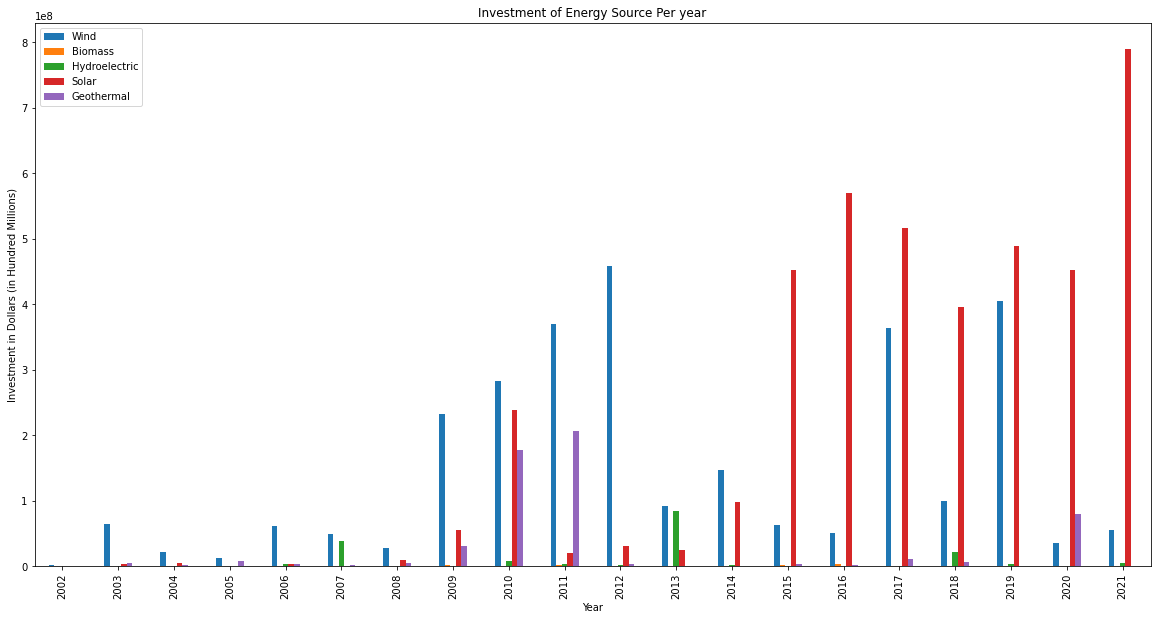

In [20]:
energy_total.plot.bar(figsize =(20,10),title= 'Investment of Energy Source Per year',ylabel='Investment in Dollars (in Hundred Millions)')

In [21]:
# Group Production Data, add 'Energy Source' field and merge as one
prod_df_merge = prod_df.groupby(["Year", "State", "Energy Source"])['Generation (Megawatthours)'].sum()
prod_df_merge2 = prod_df.groupby(["Year", "State", "Energy Source"])['Energy Source'].first().reset_index(name ='Source')
prod_df_merge = pd.merge(prod_df_merge, prod_df_merge2, on = ["Year", "State", "Energy Source"])

# Group Investment Data
inv_df_merge = inv_df.groupby(["Year", "State", "Energy Source"])['Total Number of Investments', 'Total Amount of Assistance'].sum()

# Merge Production and Investment Data
temp = pd.merge(prod_df_merge, inv_df_merge, on = ["Year", "State", "Energy Source"])

# Merge Production, Investment, and Census Data
final = pd.merge(temp, cleaned_census_df, on = ["Year", "State"])

# Final data grouped by Year, State, Energy Source - reorder columns and add data fields
final = final[['Year', 'State', 'State Name', 'Population', 'Energy Source', 'Source', 'Generation (Megawatthours)', 'Total Number of Investments', 
               'Total Amount of Assistance']]
final['Generation per Investment'] = final['Generation (Megawatthours)'] / final['Total Amount of Assistance']
final['Generation per Capita'] = final['Generation (Megawatthours)'] / final['Population']
final['# Investments per Capita'] = final['Total Number of Investments'] / final['Population']
final['Investment per Capita'] = final['Total Amount of Assistance'] / final['Population']
final

C:\Users\range\AppData\Local\Temp\ipykernel_11376\2969373998.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  inv_df_merge = inv_df.groupby(["Year", "State", "Energy Source"])['Total Number of Investments', 'Total Amount of Assistance'].sum()


,Year,State,State Name,Population,Energy Source,Source,Generation (Megawatthours),Total Number of Investments,Total Amount of Assistance,Generation per Investment,Generation per Capita,# Investments per Capita,Investment per Capita
0,2002,IA,Iowa,2929379,Biomass,Biomass,98242.0,2,143198.94,0.686053,0.033537,6.827386e-07,0.048884
1,2002,MN,Minnesota,5017355,Biomass,Biomass,503454.0,1,250000.00,2.013816,0.100343,1.993082e-07,0.049827
2,2002,MN,Minnesota,5017355,Wind,Wind,905838.0,1,148000.00,6.120527,0.180541,1.993082e-07,0.029498
3,2002,MO,Missouri,5679158,Biomass,Biomass,8560.0,2,590000.00,0.014508,0.001507,3.521649e-07,0.103889
4,2002,ND,North Dakota,633210,Biomass,Biomass,411.0,1,129972.00,0.003162,0.000649,1.579255e-06,0.205259
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331,2021,WI,Wisconsin,5895908,Biomass,Biomass,447295.0,2,500000.00,0.894590,0.075865,3.392183e-07,0.084805
1332,2021,WI,Wisconsin,5895908,Solar,Solar,392715.0,12,855892.00,0.458837,0.066608,2.035310e-06,0.145167
1333,2021,WV,West Virginia,1782959,Hydroelectric,Hydroelectric,1516181.0,1,9500.00,159.598000,0.850373,5.608654e-07,0.005328
1334,2021,WY,Wyoming,578803,Solar,Solar,179072.0,6,76739.00,2.333520,0.309383,1.036622e-05,0.132582


In [22]:
# Population per State over all years
state_pop = cleaned_census_df.groupby('State')['Population'].mean()

# Production and Investment metrics per State over all years
final_state = final.groupby(['State'])[['Generation (Megawatthours)', 'Total Number of Investments', 'Total Amount of Assistance']].sum()

# Merge to get data grouped by state over all years and add variables
final_state = pd.merge(final_state, state_pop, on = "State")

final_state['Generation per Investment'] = final_state['Generation (Megawatthours)'] / final_state['Total Amount of Assistance']
final_state['Generation per Capita'] = final_state['Generation (Megawatthours)'] / final_state['Population']
final_state['# Investments per Capita'] = final_state['Total Number of Investments'] / final_state['Population']
final_state['Investment per Capita'] = final_state['Total Amount of Assistance'] / final_state['Population']
final_state.head()

,Generation (Megawatthours),Total Number of Investments,Total Amount of Assistance,Population,Generation per Investment,Generation per Capita,# Investments per Capita,Investment per Capita
State,,,,,,,,
AK,1.170622e+07,77,8.879282e+07,706836.85,0.131837,16.561413,0.000109,125.619966
AL,2.113613e+06,577,3.924509e+07,4754364.70,0.053857,0.444563,0.000121,8.254539
AR,2.172252e+06,1223,1.765907e+08,2906275.60,0.012301,0.747435,0.000421,60.761862
AZ,4.216628e+07,182,2.220963e+08,6559313.15,0.189856,6.428460,0.000028,33.859696
CA,3.094727e+08,826,3.202177e+08,37591943.50,0.966445,8.232422,0.000022,8.518253


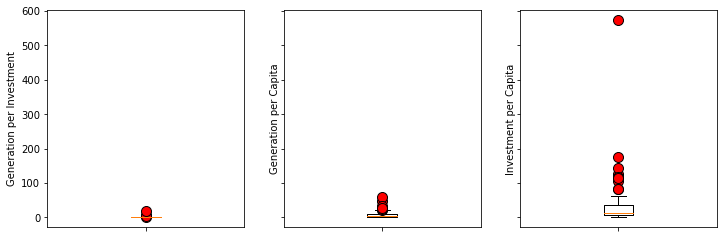

In [23]:
# Generate a box plot of the Total Generation per Investment
y_axis1 = final_state['Generation per Investment']
y_axis2 = final_state['Generation per Capita']

y_axis3 = final_state['Investment per Capita']

fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
ax[0].set_ylabel('Generation per Investment')
ax[0].boxplot(y_axis1, flierprops = {'marker': 'o', 'markersize': 10, 'markerfacecolor': 'red'})
ax[0].set_xticklabels('')

ax[1].set_ylabel('Generation per Capita')
ax[1].boxplot(y_axis2, flierprops = {'marker': 'o', 'markersize': 10, 'markerfacecolor': 'red'})
ax[1].set_xticklabels('')

ax[2].set_ylabel('Investment per Capita')
ax[2].boxplot(y_axis3, flierprops = {'marker': 'o', 'markersize': 10, 'markerfacecolor': 'red'})
ax[2].set_xticklabels('')

plt.show()

In [24]:
# Sort descending on Generation per Investment
final_state.sort_values(by=['Generation per Investment'], ascending = False)['Generation per Investment']


State
WY    19.439378
ID     7.455094
WA     3.536179
MT     1.886599
CT     1.533442
CO     1.178893
KS     0.985537
CA     0.966445
IA     0.905564
OK     0.844889
NJ     0.837536
MI     0.770152
MN     0.740850
NY     0.501809
PA     0.460250
WV     0.431286
MA     0.411711
OR     0.402540
NE     0.378765
TX     0.320140
MD     0.288851
WI     0.274937
VT     0.262569
IN     0.259238
UT     0.230957
FL     0.193916
NM     0.189875
AZ     0.189856
VA     0.168865
RI     0.158619
IL     0.144410
NH     0.142208
AK     0.131837
NV     0.122500
SD     0.120022
TN     0.119757
ME     0.093099
OH     0.085304
GA     0.082037
AL     0.053857
DE     0.047219
ND     0.044721
NC     0.042929
SC     0.028016
KY     0.025854
HI     0.025357
MO     0.024270
MS     0.016958
AR     0.012301
LA     0.004603
Name: Generation per Investment, dtype: float64

In [25]:
# Sort descending on Generation per Capita
final_state.sort_values(by=['Generation per Capita'], ascending = False)['Generation per Capita']

State
ID    60.675216
IA    47.086371
OR    33.546666
WA    28.740038
MN    25.882558
ND    25.664048
MT    22.864790
KS    20.899785
WY    19.009415
AK    16.561413
NV    14.259671
SD    13.839915
ME     9.913014
NE     9.768342
VT     8.742185
CO     8.413015
CA     8.232422
OK     8.045864
NM     6.889902
AZ     6.428460
NY     6.301932
NC     6.162781
UT     5.814529
TX     4.654093
HI     4.418931
MA     4.305937
WI     2.926961
PA     2.814633
VA     2.777054
FL     2.632630
MI     2.618158
CT     2.439512
SC     2.351150
NJ     2.043773
GA     2.009056
IL     1.976004
NH     1.874269
RI     1.871521
IN     1.818919
DE     1.580884
WV     1.457964
MD     1.373322
AR     0.747435
OH     0.593800
MS     0.587632
AL     0.444563
MO     0.402288
TN     0.380874
KY     0.328506
LA     0.288718
Name: Generation per Capita, dtype: float64

In [26]:
# Sort descending on Investment per Capita
final_state.sort_values(by=['Investment per Capita'], ascending = False)['Investment per Capita']

State
ND    573.870742
HI    174.269969
NC    143.557418
AK    125.619966
NV    116.405332
SD    115.311669
ME    106.477806
SC     83.920607
OR     83.337492
LA     62.727640
AR     60.761862
IA     51.996748
NM     36.286507
MN     34.936280
MS     34.653002
AZ     33.859696
DE     33.479582
VT     33.294801
NE     25.790007
UT     25.175766
GA     24.489656
KS     21.206488
MO     16.575817
VA     16.445439
TX     14.537679
IL     13.683323
FL     13.576132
NH     13.179769
KY     12.706392
NY     12.558426
MT     12.119584
RI     11.798872
WI     10.645922
MA     10.458634
OK      9.522980
CA      8.518253
AL      8.254539
ID      8.138759
WA      8.127427
CO      7.136370
IN      7.016393
OH      6.960990
PA      6.115441
MD      4.754424
MI      3.399533
WV      3.380501
TN      3.180389
NJ      2.440223
CT      1.590874
WY      0.977882
Name: Investment per Capita, dtype: float64

The correlation between investment and production is 0.24


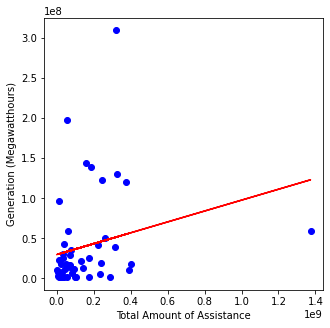

In [27]:
# Scatter plot for Investment vs Generation
# x values
x_vals = final_state['Total Amount of Assistance']

# y values
y_vals = final_state['Generation (Megawatthours)']

# Get metrics for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_vals, y_vals)
regress_values = x_vals * slope + intercept

# print correlation coefficient
print(f"The correlation between investment and production is {round(rvalue,2)}")

# Scatter plot with best fit line
plt.figure(figsize = (5, 5))
scat_plot2 = plt.scatter(x_vals, y_vals, marker="o", facecolors="blue", edgecolors="blue")
plt.xlabel("Total Amount of Assistance")
plt.ylabel("Generation (Megawatthours)")
plt.plot(x_vals, regress_values, "r-")
plt.show()


The correlation between population and production is 0.63


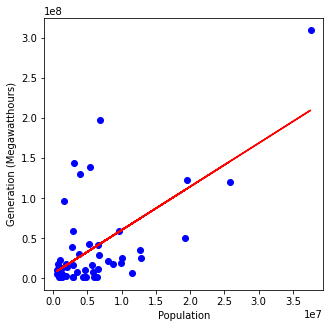

In [28]:
# Scatter plot for Population vs Production
# x values
x_vals = final_state['Population']

# y values
y_vals = final_state['Generation (Megawatthours)']

# Get metrics for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_vals, y_vals)
regress_values = x_vals * slope + intercept

# print correlation coefficient
print(f"The correlation between population and production is {round(rvalue,2)}")

# Scatter plot with best fit line
plt.figure(figsize = (5, 5))
scat_plot2 = plt.scatter(x_vals, y_vals, marker="o", facecolors="blue", edgecolors="blue")
plt.xlabel("Population")
plt.ylabel("Generation (Megawatthours)")
plt.plot(x_vals, regress_values, "r-")
plt.show()

The correlation between population and investment is 0.29


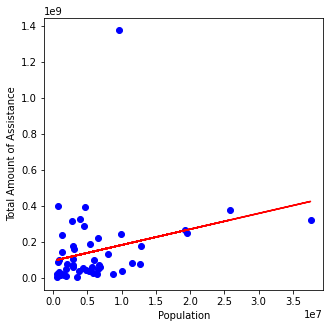

In [29]:
# Scatter plot for Population vs Investment
# x values
x_vals = final_state['Population']

# y values
y_vals = final_state['Total Amount of Assistance']

# Get metrics for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_vals, y_vals)
regress_values = x_vals * slope + intercept

# print correlation coefficient
print(f"The correlation between population and investment is {round(rvalue,2)}")

# Scatter plot with best fit line
plt.figure(figsize = (5, 5))
scat_plot2 = plt.scatter(x_vals, y_vals, marker="o", facecolors="blue", edgecolors="blue")
plt.xlabel("Population")
plt.ylabel("Total Amount of Assistance")
plt.plot(x_vals, regress_values, "r-")
plt.show()

The correlation between population and investment is 0.22


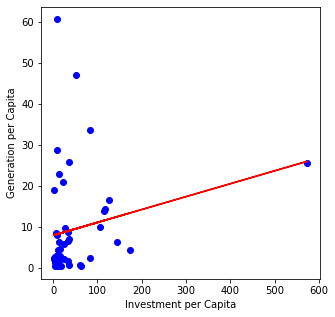

In [30]:
# Scatter plot for Investment per Capita vs Generation per Capita
# x values
x_vals = final_state['Investment per Capita']

# y values
y_vals = final_state['Generation per Capita']

# Get metrics for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_vals, y_vals)
regress_values = x_vals * slope + intercept

# print correlation coefficient
print(f"The correlation between population and investment is {round(rvalue,2)}")

# Scatter plot with best fit line
plt.figure(figsize = (5, 5))
scat_plot2 = plt.scatter(x_vals, y_vals, marker="o", facecolors="blue", edgecolors="blue")
plt.xlabel("Investment per Capita")
plt.ylabel("Generation per Capita")
plt.plot(x_vals, regress_values, "r-")
plt.show()

In [31]:
# Group Production Data by State and Energy Source, add 'Energy Source' field and merge as one
prod_df_mrg = prod_df.groupby(["State", "Energy Source"])['Generation (Megawatthours)'].sum()
prod_df_mrg2 = prod_df.groupby(["State", "Energy Source"])['Energy Source'].first().reset_index(name ='Source')
prod_df_mrg = pd.merge(prod_df_mrg, prod_df_mrg2, on = ["State", "Energy Source"])

# Group Investment Data
inv_df_mrg = inv_df.groupby(["State", "Energy Source"])['Total Number of Investments', 'Total Amount of Assistance'].sum()

# Merge Production and Investment Data
temp_mrg = pd.merge(prod_df_mrg, inv_df_mrg, on = ["State", "Energy Source"])

# Merge Production, Investment, and Census Data
final_mrg = pd.merge(temp_mrg, state_pop, on = "State")

# Final data grouped by State and Energy Source - reorder columns and add data fields
final_mrg = final_mrg[['State', 'Population', 'Energy Source', 'Source', 'Generation (Megawatthours)', 'Total Number of Investments', 'Total Amount of Assistance']]
final_mrg['Generation per Investment'] = final_mrg['Generation (Megawatthours)'] / final_mrg['Total Amount of Assistance']
final_mrg['Generation per Capita'] = final_mrg['Generation (Megawatthours)'] / final_mrg['Population']
final_mrg['# Investments per Capita'] = final_mrg['Total Number of Investments'] / final_mrg['Population']
final_mrg['Investment per Capita'] = final_mrg['Total Amount of Assistance'] / final_mrg['Population']
final_mrg

C:\Users\range\AppData\Local\Temp\ipykernel_11376\137551443.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  inv_df_mrg = inv_df.groupby(["State", "Energy Source"])['Total Number of Investments', 'Total Amount of Assistance'].sum()


,State,Population,Energy Source,Source,Generation (Megawatthours),Total Number of Investments,Total Amount of Assistance,Generation per Investment,Generation per Capita,# Investments per Capita,Investment per Capita
0,AK,706836.85,Biomass,Biomass,475893.06,37,7344597.85,0.064795,0.673271,5.234588e-05,10.390796
1,AK,706836.85,Hydroelectric,Hydroelectric,29881416.81,11,53877554.00,0.554617,42.274843,1.556229e-05,76.223465
2,AK,706836.85,Wind,Wind,1394732.85,29,27570669.50,0.050588,1.973203,4.102786e-05,39.005705
3,AL,4754364.70,Biomass,Biomass,505249.65,536,37311692.79,0.013541,0.106271,1.127385e-04,7.847882
4,AL,4754364.70,Solar,Solar,1818254.00,53,2462549.27,0.738362,0.382439,1.114765e-05,0.517955
...,...,...,...,...,...,...,...,...,...,...,...
153,WV,1818457.95,Biomass,Biomass,56998.58,85,6111221.60,0.009327,0.031344,4.674290e-05,3.360661
154,WV,1818457.95,Hydroelectric,Hydroelectric,29587279.02,1,9500.00,3114.450423,16.270532,5.499165e-07,0.005224
155,WV,1818457.95,Wind,Wind,19548818.31,1,50000.00,390.976366,10.750217,5.499165e-07,0.027496
156,WY,551726.45,Solar,Solar,525398.00,40,625986.20,0.839312,0.952280,7.249970e-05,1.134595


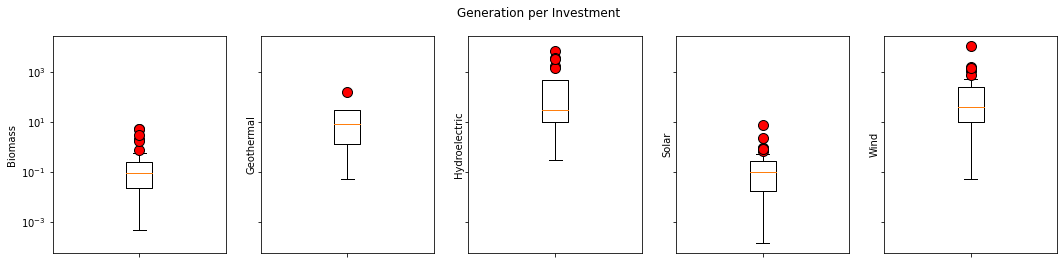

In [32]:
# Box Plot 
# Filter final df for each Energy Source and compare side-by-side
final_mrg_bio = final_mrg.loc[final_mrg['Energy Source'] == source_list[0]]['Generation per Investment']
final_mrg_geo = final_mrg.loc[final_mrg['Energy Source'] == source_list[1]]['Generation per Investment']
final_mrg_hyd = final_mrg.loc[final_mrg['Energy Source'] == source_list[2]]['Generation per Investment']
final_mrg_sol = final_mrg.loc[final_mrg['Energy Source'] == source_list[3]]['Generation per Investment']
final_mrg_wnd = final_mrg.loc[final_mrg['Energy Source'] == source_list[4]]['Generation per Investment']

# Generate a box plot of the Total Generation per Investment
y_axis1 = final_mrg_bio
y_axis2 = final_mrg_geo
y_axis3 = final_mrg_hyd
y_axis4 = final_mrg_sol
y_axis5 = final_mrg_wnd

fig, ax = plt.subplots(1, 5, figsize=(18, 4), sharey=True)
ax[0].set_ylabel(source_list[0])
ax[0].boxplot(y_axis1, flierprops = {'marker': 'o', 'markersize': 10, 'markerfacecolor': 'red'})
ax[0].set_xticklabels('')

ax[1].set_ylabel(source_list[1])
ax[1].boxplot(y_axis2, flierprops = {'marker': 'o', 'markersize': 10, 'markerfacecolor': 'red'})
ax[1].set_xticklabels('')

ax[2].set_ylabel(source_list[2])
ax[2].boxplot(y_axis3, flierprops = {'marker': 'o', 'markersize': 10, 'markerfacecolor': 'red'})
ax[2].set_xticklabels('')

ax[3].set_ylabel(source_list[3])
ax[3].boxplot(y_axis4, flierprops = {'marker': 'o', 'markersize': 10, 'markerfacecolor': 'red'})
ax[3].set_xticklabels('')

ax[4].set_ylabel(source_list[4])
ax[4].boxplot(y_axis5, flierprops = {'marker': 'o', 'markersize': 10, 'markerfacecolor': 'red'})
ax[4].set_xticklabels('')

fig.suptitle('Generation per Investment')
plt.yscale("log")
plt.show()

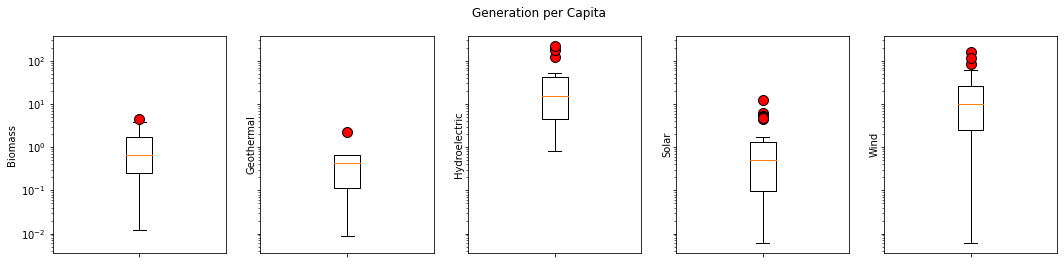

In [33]:
# Box Plot 
# Filter final df for each Energy Source and compare side-by-side
final_mrg_bio = final_mrg.loc[final_mrg['Energy Source'] == source_list[0]]['Generation per Capita']
final_mrg_geo = final_mrg.loc[final_mrg['Energy Source'] == source_list[1]]['Generation per Capita']
final_mrg_hyd = final_mrg.loc[final_mrg['Energy Source'] == source_list[2]]['Generation per Capita']
final_mrg_sol = final_mrg.loc[final_mrg['Energy Source'] == source_list[3]]['Generation per Capita']
final_mrg_wnd = final_mrg.loc[final_mrg['Energy Source'] == source_list[4]]['Generation per Capita']

# Generate a box plot of the Total Generation per Capita
y_axis1 = final_mrg_bio
y_axis2 = final_mrg_geo
y_axis3 = final_mrg_hyd
y_axis4 = final_mrg_sol
y_axis5 = final_mrg_wnd

fig, ax = plt.subplots(1, 5, figsize=(18, 4), sharey=True)
ax[0].set_ylabel(source_list[0])
ax[0].boxplot(y_axis1, flierprops = {'marker': 'o', 'markersize': 10, 'markerfacecolor': 'red'})
ax[0].set_xticklabels('')

ax[1].set_ylabel(source_list[1])
ax[1].boxplot(y_axis2, flierprops = {'marker': 'o', 'markersize': 10, 'markerfacecolor': 'red'})
ax[1].set_xticklabels('')

ax[2].set_ylabel(source_list[2])
ax[2].boxplot(y_axis3, flierprops = {'marker': 'o', 'markersize': 10, 'markerfacecolor': 'red'})
ax[2].set_xticklabels('')

ax[3].set_ylabel(source_list[3])
ax[3].boxplot(y_axis4, flierprops = {'marker': 'o', 'markersize': 10, 'markerfacecolor': 'red'})
ax[3].set_xticklabels('')

ax[4].set_ylabel(source_list[4])
ax[4].boxplot(y_axis5, flierprops = {'marker': 'o', 'markersize': 10, 'markerfacecolor': 'red'})
ax[4].set_xticklabels('')

fig.suptitle('Generation per Capita')
plt.yscale("log")
plt.show()

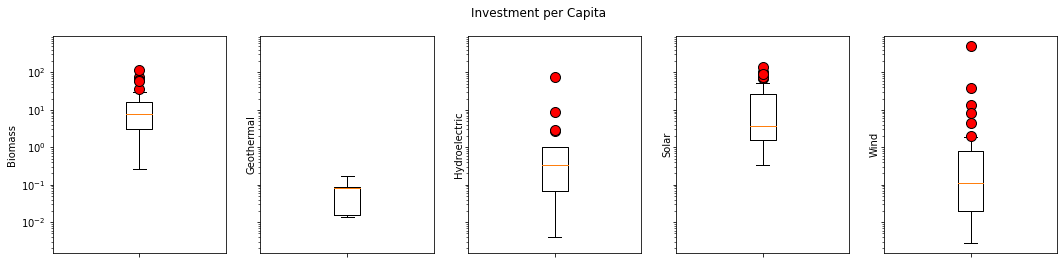

In [34]:
# Box Plot 
# Filter final df for each Energy Source and compare side-by-side
final_mrg_bio = final_mrg.loc[final_mrg['Energy Source'] == source_list[0]]['Investment per Capita']
final_mrg_geo = final_mrg.loc[final_mrg['Energy Source'] == source_list[1]]['Investment per Capita']
final_mrg_hyd = final_mrg.loc[final_mrg['Energy Source'] == source_list[2]]['Investment per Capita']
final_mrg_sol = final_mrg.loc[final_mrg['Energy Source'] == source_list[3]]['Investment per Capita']
final_mrg_wnd = final_mrg.loc[final_mrg['Energy Source'] == source_list[4]]['Investment per Capita']

# Generate a box plot of the Total Investment per Capita
y_axis1 = final_mrg_bio
y_axis2 = final_mrg_geo
y_axis3 = final_mrg_hyd
y_axis4 = final_mrg_sol
y_axis5 = final_mrg_wnd

fig, ax = plt.subplots(1, 5, figsize=(18, 4), sharey=True)
ax[0].set_ylabel(source_list[0])
ax[0].boxplot(y_axis1, flierprops = {'marker': 'o', 'markersize': 10, 'markerfacecolor': 'red'})
ax[0].set_xticklabels('')

ax[1].set_ylabel(source_list[1])
ax[1].boxplot(y_axis2, flierprops = {'marker': 'o', 'markersize': 10, 'markerfacecolor': 'red'})
ax[1].set_xticklabels('')

ax[2].set_ylabel(source_list[2])
ax[2].boxplot(y_axis3, flierprops = {'marker': 'o', 'markersize': 10, 'markerfacecolor': 'red'})
ax[2].set_xticklabels('')

ax[3].set_ylabel(source_list[3])
ax[3].boxplot(y_axis4, flierprops = {'marker': 'o', 'markersize': 10, 'markerfacecolor': 'red'})
ax[3].set_xticklabels('')

ax[4].set_ylabel(source_list[4])
ax[4].boxplot(y_axis5, flierprops = {'marker': 'o', 'markersize': 10, 'markerfacecolor': 'red'})
ax[4].set_xticklabels('')

fig.suptitle('Investment per Capita')
plt.yscale("log")
plt.show()

In [35]:
nc_df = inv_df.loc[inv_df['State Name'] == 'North Carolina']
nc_df

,State Name,County,Congressional District,Zip Code,Energy Source,Agency,Year,Program Name,Total Number of Investments,Total Amount of Assistance,Description,State
9710,North Carolina,Bertie,NC-01,27957,Biomass,FSA,2010,BCAP Matching Payments (NOFA),10,296741.0,NaN,NC
9711,North Carolina,Bertie,NC-01,27983,Biomass,FSA,2010,BCAP Matching Payments (NOFA),2,9064.0,NaN,NC
9712,North Carolina,Edgecombe,NC-01,27801,Biomass,RBS,2008,Value-Added Producer Grant (VAPG),1,100000.0,Biodiesel Production,NC
9713,North Carolina,Edgecombe,NC-01,27881,Biomass,FSA,2010,BCAP Matching Payments (NOFA),1,8550.0,NaN,NC
9714,North Carolina,Gates,NC-01,27938,Biomass,FSA,2010,BCAP Matching Payments (NOFA),1,96161.0,NaN,NC
...,...,...,...,...,...,...,...,...,...,...,...,...
10245,North Carolina,Halifax,VA-01,27823,Solar,RBS,2021,Rural Energy for America Program (REAP),1,7500000.0,Solar Electric,NC
10246,North Carolina,Halifax,VA-01,27839,Solar,RBS,2021,Renewable Energy Systems (REAP),1,2275000.0,Solar Electric,NC
10247,North Carolina,Stokes,VA-05,27052,Solar,RBS,2021,Business & Industry Guaranteed Loan Program,1,8000000.0,Solar Electric,NC
10248,North Carolina,Stokes,VA-05,27052,Solar,RBS,2021,Rural Energy for America Program (REAP),1,25000000.0,Solar Electric,NC


In [36]:
nc_per_year = nc_df.groupby(['Year', 'Energy Source'])['Total Amount of Assistance'].sum()
nc_per_year

Year  Energy Source
2005  Solar            2.500000e+03
2006  Solar            6.056000e+03
2007  Biomass          2.534210e+05
      Solar            3.603000e+03
2008  Biomass          1.879590e+05
      Solar            4.888000e+03
2009  Biomass          4.206859e+06
      Solar            8.091400e+04
2010  Biomass          6.031661e+06
      Solar            6.477340e+05
      Wind             8.947800e+04
2011  Biomass          6.986972e+05
      Geothermal       4.900000e+04
      Hydroelectric    1.462810e+05
      Solar            4.135317e+06
2012  Biomass          8.113211e+05
      Solar            1.047382e+07
2013  Biomass          2.249040e+05
      Geothermal       7.403000e+03
      Hydroelectric    3.650000e+06
      Solar            1.031753e+07
2014  Biomass          4.311392e+05
      Solar            6.801209e+07
2015  Biomass          4.922155e+06
      Solar            1.884340e+08
2016  Biomass          2.349551e+06
      Solar            1.872831e+08
2017  Bi

In [37]:
nc_year= pd.DataFrame(nc_per_year)

In [38]:
nc_year_df=nc_year.reset_index()
nc_year_df


,Year,Energy Source,Total Amount of Assistance
0,2005,Solar,2.500000e+03
1,2006,Solar,6.056000e+03
2,2007,Biomass,2.534210e+05
3,2007,Solar,3.603000e+03
4,2008,Biomass,1.879590e+05
5,2008,Solar,4.888000e+03
6,2009,Biomass,4.206859e+06
7,2009,Solar,8.091400e+04
8,2010,Biomass,6.031661e+06
9,2010,Solar,6.477340e+05


In [39]:
nc_table = nc_year_df.pivot_table(index="Year", columns="Energy Source", values="Total Amount of Assistance")
nc_table

Energy Source,Biomass,Geothermal,Hydroelectric,Solar,Wind
Year,,,,,
2005,NaN,NaN,NaN,2.500000e+03,NaN
2006,NaN,NaN,NaN,6.056000e+03,NaN
2007,253421.00,NaN,NaN,3.603000e+03,NaN
2008,187959.00,NaN,NaN,4.888000e+03,NaN
2009,4206859.40,NaN,NaN,8.091400e+04,NaN
2010,6031660.65,NaN,NaN,6.477340e+05,89478.0
2011,698697.25,49000.0,146281.0,4.135317e+06,NaN
2012,811321.09,NaN,NaN,1.047382e+07,NaN
2013,224904.00,7403.0,3650000.0,1.031753e+07,NaN


<AxesSubplot:title={'center':'North Carolina per Year Investment'}, xlabel='Year', ylabel='Investment in Dollars(hundred millions)'>

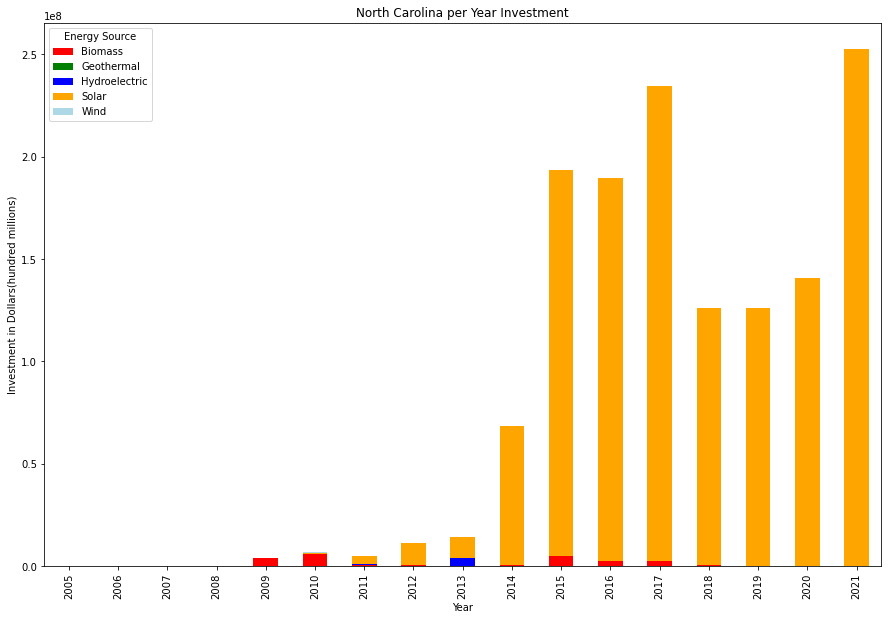

In [40]:
nc_table.plot(kind='bar', figsize=(15,10),stacked=True, title='North Carolina per Year Investment', ylabel='Investment in Dollars(hundred millions)',color=colors)